<a href="https://colab.research.google.com/github/dniggl/Extract-Data-From-PDF-/blob/main/Sentiment_Analysis_on_Democracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sentiment analysis on tweets related to Democracy.   

**Install the Package**

To get started you will need to install the tweepy package. Tweepy is an open source Python package that gives you an easy way to access the Twitter API with Python. 

In [ ]:
# Install Tweepy
!pip install tweepy

**Import the Libraries**

In [ ]:
# Import the required libraries.
import os
import tweepy as tw
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
import re
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


**Get Twitter Data**

For this project, we are going to extract data from Twitter using the Tritter API. You are required to set up a Twitter developer account prior to using their API. I will not cover this process here, but you can find out how by going to this link https://python.plainenglish.io/scraping-twitter-data-with-an-api-and-python-445a4de4b18  

After you have set up your Twitter developer accont and obtained your api keys and access tokens, you will assign them to variables. For clarity, I have assigned variable names that match the type of api key or access token.

In [ ]:
# Connecting to your Twitter Developer API's.
api_key= 'enter your api key' 
api_secret= 'enter your api secret key here'
access_token= 'enter your access token here'
access_token_secret= 'enter your access token secret here'

Next we need to authenticate the API keys and Access Tokens.

In [ ]:
# Authenticate the APIs
auth = tw.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

We will now create variables for the words we will search for and the start date of the search.  

In [ ]:
# Define variables for search words and the start date. 
search_words = "democracy"
date_since = "2021-01-01"

Collect the tweets using the search words and start date.

In [ ]:
# Collect the tweets.
tweets = tw.Cursor(api.search,
              q = search_words,
              lang = "en",
              since = date_since).items(5000)

Define a function to get Twitter users, tweet times, and tweet text for tweets that match the search criteria and create a new data frame.

In [ ]:
# Define a function to get the related tweets.
def get_related_tweets(key_word):
    twitter_users = []
    tweet_time = []
    tweet_string = [] 
    for tweet in tw.Cursor(api.search,q=key_word, count=5000).items(5000):
             if (not tweet.retweeted) and ('RT @' not in tweet.text):
                if tweet.lang == "en":
                    twitter_users.append(tweet.user.name)
                    tweet_time.append(tweet.created_at)
                    tweet_string.append(tweet.text)
                    
    df = pd.DataFrame({'name':twitter_users, 'time': tweet_time, 'tweet': tweet_string})
    df.to_csv(f"{key_word}.csv")
    return df

Call the function to get tweets that contain text containing the word democracy with a start date equal to or greater than 01/01/2022 and display a few of the tweets.

In [ ]:
# Get tweets related to domocracy and create a new dataframe.
df = get_related_tweets("democracy")
df.head(5)

,name,time,tweet
0,Michael Bruner,2022-10-10 21:14:58,@tomselliott @NicolleDWallace Maybe instead of...
1,🇺🇦🇺🇸Defeat Trumpism (士雅) 😷,2022-10-10 21:14:55,"@GOPLeader Coward Kev will defend racists, ant..."
2,Yusful Obong Obidient,2022-10-10 21:14:54,@Pinktourmline @BashirAhmaad Obi's ruthlessnes...
3,claudjarae🌵,2022-10-10 21:14:49,Incredibly important for @katiehobbs for Gover...
4,Kevin Sabo,2022-10-10 21:14:48,Anti-Black racism in Los Angeles politics is a...


There are 1,140 tweets in the dataframe.

**Data Cleaning**

The text within tweets contain many slang words and punctuation marks. We need to pre-process and clean the text in the tweets before they can be used for sentiment analysis. Text preprocessing is one of the most important tasks in Natural Language Processing (NLP). For example, you may want to remove all punctuation marks within the text before they can be used for text classification.

We will now create a variable that contains only the text from the tweets.

In [ ]:
# Create variable containing tweets.  
tweets = df.iloc[:, 2].values

We will use Regular Expressions (Regex) to perform the text pre-processing tasks. A Regular Expression is a text string that describes a search pattern which can be used to match or replace patterns inside a string with a minimal amount of code. Python’s re package will be used to implement regular expressions. To learn more about regular expressions, click this link https://stackabuse.com/using-regex-for-text-manipulation-in-python/

In [ ]:
# Clean the text data by preprocessing it with Regex. 
processed_tweets = []

for sentence in range(0, len(tweets)):
    # Remove all the special characters.
    processed_tweet = re.sub(r'\W', ' ', str(tweets[sentence]))

    # Remove all single characters as a result of removing the special characters.
    processed_tweet= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)

    # Remove single characters from the start.
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 

    # Replace multiple spaces with a single space.
    processed_tweet = re.sub(r'\s+', ' ', processed_tweet, flags=re.I)

    # Remove links from text.
    processed_tweet = re.sub(r'http\S+', '', processed_tweet)

    # Remove prefixed 'b'.
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)

    processed_tweets.append(processed_tweet)

In [ ]:
# Create a new data frame for the processed tweets. 
clean_tweets = pd.DataFrame({'tweet': processed_tweets})
clean_tweets.head(5)

,tweet
0,tomselliott NicolleDWallace Maybe instead of ...
1,GOPLeader Coward Kev will defend racists anti...
2,Pinktourmline BashirAhmaad Obi ruthlessness a...
3,Incredibly important for katiehobbs for Govern...
4,Anti Black racism in Los Angeles politics is a...


**Apply Sentiment Analysis**

Sentiment analysis is a text analysis method that detects polarity (positive or negative opinion) within text. We will use the NLTK (Natural Language Toolkit)  submodule VADER for doing sentiment analysis on the text. 

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a module used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is applied directly to unlabeled text data and is specifically designed for sentiments expressed in social media.

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of the following categories:
* negative
* neutral
* positive
* compound (the sum of positive, negative & neutral scores which is then normalized between -1(strongly negative) and +1 (strongly positive).

For example, the following text would return these output  scores:                       
'This was the best, most awesome movie EVER MADE!!!'                       
OUTPUT-{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}

The scores range between -1 to 1, with -1 being strongly negative and +1 being strongly positive. We will use the compound score to determine if tweets related to democracy are positive or negative. 

We will now initialize the Sentiment Intensity Analyzer and create a lambda function that takes in a text string, applies the vader.polarity_scores() function on it to get the results and then return back the compound scores. Using the apply function in Pandas, we can create a new compound column in the data frame with all the compound scores for each tweet.

In [ ]:
# Initialize the SentimentIntensityAnalyzer.
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']
clean_tweets['compound'] = clean_tweets['tweet'].apply(function)

In [ ]:
clean_tweets  

,tweet,compound
0,tomselliott NicolleDWallace Maybe instead of ...,0.0000
1,GOPLeader Coward Kev will defend racists anti...,-0.7906
2,Pinktourmline BashirAhmaad Obi ruthlessness a...,-0.3612
3,Incredibly important for katiehobbs for Govern...,-0.4098
4,Anti Black racism in Los Angeles politics is a...,-0.8402
...,...,...
1135,If we want Democracy to flour sh we ll have to...,0.0772
1136,FACE Partners with Faiths United to Save Democ...,0.9042
1137,DavidNC__AV Doesn seem true He did not influe...,0.4215
1138,AmbQinGang Hi dictator lover Why wont you sup...,0.1295


**Visualize Sentiments**

Let’s see how the sentiments are distributed. We can better understand the common words by plotting word clouds. A word cloud (also known as text clouds) is a visualization where the more a specific word appears in the text, the bigger and bolder it will appear in the word cloud.

Let’s visualize all the words in the data using the word cloud plot.  

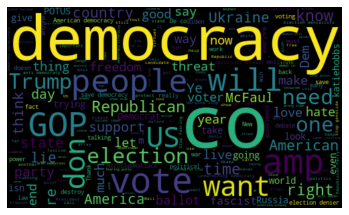

In [ ]:
# Word cloud visualization.
allWords = ' '.join([twts for twts in clean_tweets['tweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Democracy, will, GOP and vote are common words that stand out.

Create a function to compute the negative (-1), neutral (0), and positive (+1) sentiments, and add a new column called sentiment to our data frame.

In [ ]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) sentiments.
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

clean_tweets['sentiment'] = clean_tweets['compound'].apply(getAnalysis)

# Show the dataframe
clean_tweets

,tweet,compound,sentiment
0,tomselliott NicolleDWallace Maybe instead of ...,0.0000,Neutral
1,GOPLeader Coward Kev will defend racists anti...,-0.7906,Negative
2,Pinktourmline BashirAhmaad Obi ruthlessness a...,-0.3612,Negative
3,Incredibly important for katiehobbs for Govern...,-0.4098,Negative
4,Anti Black racism in Los Angeles politics is a...,-0.8402,Negative
...,...,...,...
1135,If we want Democracy to flour sh we ll have to...,0.0772,Positive
1136,FACE Partners with Faiths United to Save Democ...,0.9042,Positive
1137,DavidNC__AV Doesn seem true He did not influe...,0.4215,Positive
1138,AmbQinGang Hi dictator lover Why wont you sup...,0.1295,Positive


Show the counts for each sentiment type.  

In [ ]:
# Show the counts for each sentiment.
clean_tweets['sentiment'].value_counts()

Negative    460
Positive    414
Neutral     266
Name: sentiment, dtype: int64

There are a total of 1,140 tweets. We see that 460 tweets are negative, 414  are negative and 266 are neutral.

Visualize the counts for each sentiment.

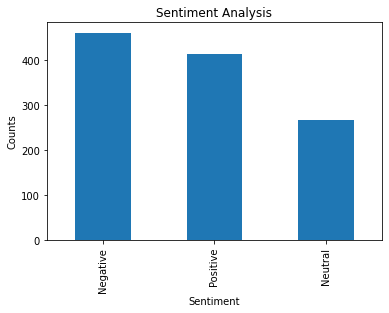

In [ ]:
# Plotting the counts.
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
clean_tweets['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Visualize the distribution of sentiments across all tweets.

Text(0, 0.5, 'Sentiments for Democracy')

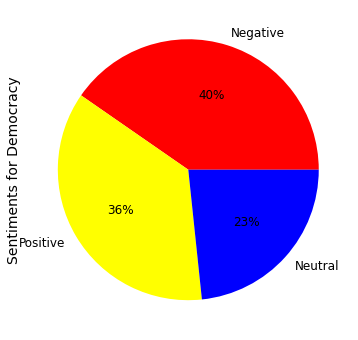

In [ ]:
# Visualize the distribution of sentiment across all tweets.
clean_tweets.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%',  fontsize=12, figsize=(9,6), colors=["red", "yellow", "blue"])
plt.ylabel("Sentiments for Democracy", size=14)

Visualize sentiments distribution based on compound scores.

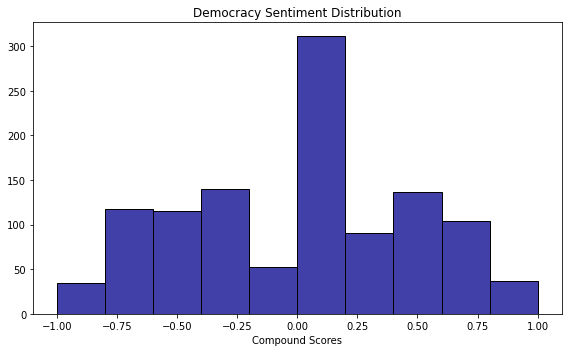

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(clean_tweets, x='compound', color="darkblue", bins=10, binrange=(-1, 1))
plt.title("Democracy Sentiment Distribution")
plt.xlabel("Compound Scores")
plt.ylabel("")
plt.tight_layout()

**Conclusions**


There were slightly more negative sentiments (460) then positive sentiments tweets (414) toward democracy. There were a significant number of neutral sentiments (266) toward democracy. 40% of sentiments were negative, 36% were positive, and 23% were neutral. These numbers support the current division within our country between conservative and progressive factions. Those individuals with neutral sentiments may well determine which party will prevail and determine the future course of democracy.
                           